In [1]:
import episuite
from matplotlib import pyplot as plt

from episuite import icu, durations, distributions
from episuite import data

### Preparing admissions
The first step is to prepare the admissions that we want to use for simulation. These admissions can be observed and corrected for right-censoring or projected admissions to simulate different scenarios.

In [2]:
sample_data = data.admissions_sample()

In [3]:
sample_data_admissions = sample_data.groupby("DATE_START").size().sort_index()
sample_data_admissions = sample_data_admissions.resample("D").sum().fillna(0)
admissions = icu.ICUAdmissions(sample_data_admissions)

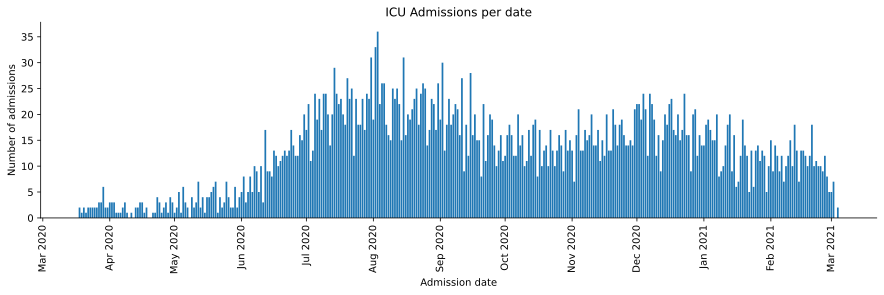

In [4]:
fig = plt.figure(figsize=(15, 4))
admissions.plot.bar()
plt.show()

### Durations (length of stay)
Let's now prepare the duration distribution, for the observed length of stay (LoS).

In [5]:
dur = durations.Durations(sample_data)

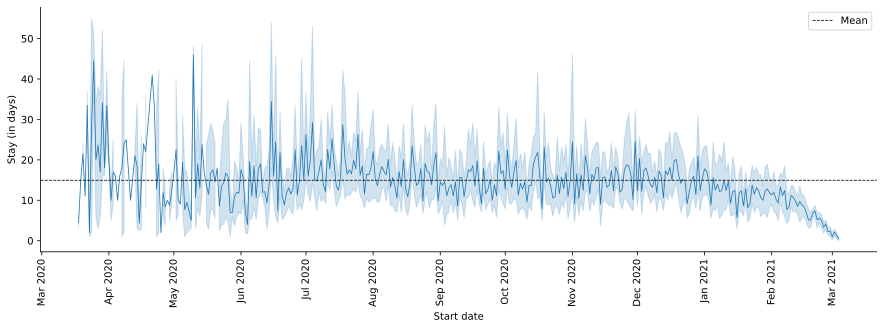

In [6]:
fig = plt.figure(figsize=(15, 5))
dur.plot.timeplot(n_boot=100)
plt.show()

As we can see in the figure above, the LoS for the ICU occupation varies a lot in the beginning of the pandemic and then stabilizes later with a drop at the end due to a bias present in the dataset. This bias would ideally be corrected in order to do nowcasting or forecasting for different scenarios.

Now, we are going to get a bootstrap distribution for the LoS and the instantiate the `ICUSimulation` using this distribution of stays and the admissions we observed.

In [7]:
duration_bootstrap = dur.get_bootstrap()
icu_sim = icu.ICUSimulation(admissions, duration_bootstrap)

We will now simulate 5 rounds to incorporate the uncertainty of the LoS distribution. Usually you would do more than 50 rounds.

In [8]:
results = icu_sim.simulate(5)

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

We can now compute confidence intervals and inspect the simulation results. The method `get_simulation_results()` will give you a dataframe indexed by day and with each simulation as a column, representing different occupancy values for each day and taking the LoS uncertainty into account.

In [9]:
results.get_simulation_results()

,0,1,2,3,4
2020-03-18,2.0,2.0,2.0,2.0,2
2020-03-19,3.0,3.0,3.0,3.0,3
2020-03-20,5.0,5.0,5.0,5.0,5
2020-03-21,6.0,6.0,6.0,6.0,6
2020-03-22,8.0,8.0,8.0,8.0,7
...,...,...,...,...,...
2021-06-17,0.0,0.0,0.0,0.0,1
2021-06-18,0.0,0.0,0.0,0.0,1
2021-06-19,0.0,0.0,0.0,0.0,1
2021-06-20,0.0,0.0,0.0,0.0,1


To compute confidence intervals, we just have to call the `hdi()` method. This will result a dataframe with the confidence intervals (lb95 = lower bound .95 HDI, ub95 = upper bound .95 HDI).

In [10]:
df = results.hdi()

In [11]:
df.head()

,date,lb95,ub95,lb50,ub50,mean_val,median_val
0,2020-03-18,2.0,2.0,2.0,2.0,2.0,2.0
1,2020-03-19,3.0,3.0,3.0,3.0,3.0,3.0
2,2020-03-20,5.0,5.0,5.0,5.0,5.0,5.0
3,2020-03-21,6.0,6.0,6.0,6.0,6.0,6.0
4,2020-03-22,7.0,8.0,8.0,8.0,7.8,8.0


### Visualization

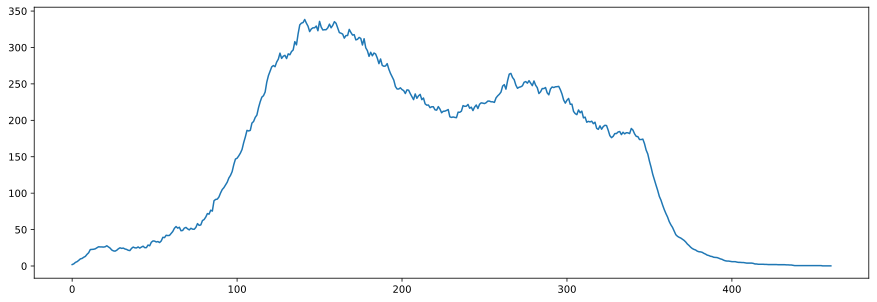

In [12]:
fig = plt.figure(figsize=(15, 5))
df["mean_val"].plot()
plt.show()

We can see here the results of the simulation and the uncertainty for each day. You can see that after stopping admissions, to have a drop to zero occupancy we need to wait for more than one month. This shows also how concerning are COVID-19 hospitalizations, they rise quickly but take a lot of time to dissipate.

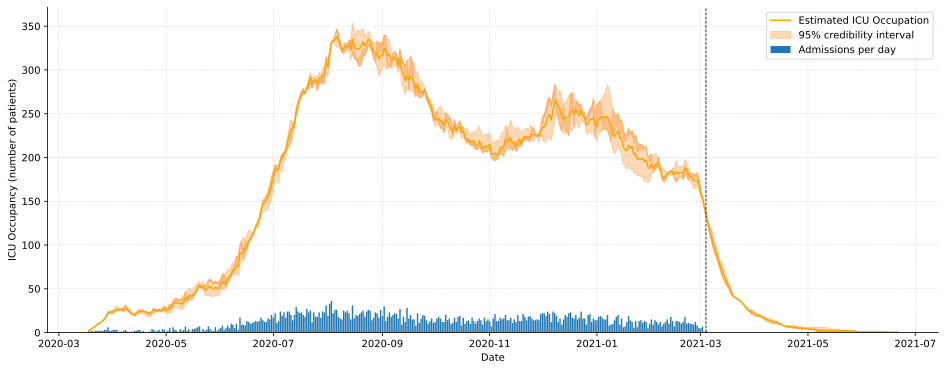

In [13]:
fig = plt.figure(figsize=(16, 6))
results.plot.lineplot()
plt.show()